# Classification model analysis

Models copy : <br>
In the folder of your choice : <br>
```gsutil cp -r gs://art-recognition-app/models . ```<br>
Warning : remove v1, v2, and wrong v3/4 (20201211_174935_VGG16_v3_1 or 20201211_174935_VGG16_v4_1) data to start with correct data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path_models = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition\models\Full_training'

In [ ]:
files = os.listdir(path_models)
models_list = [f for f in files if f.find('.')==-1]
models_list

## Models log info
For each model, load txt and csv, put everything in a df

In [20]:
dict_recap = []
for model in models_list:
    history = pd.read_csv(os.path.join(path_models, model+'.csv'))
    with open(os.path.join(path_models, model+'.txt')) as f:
        lines = f.readlines()
    
    emb_size_str = [s for s in lines if 'Embedding size' in s]
    emb_size = int(emb_size_str[0].replace('Embedding size:', '').replace('\n', ''))
    
    data_aug_str = [s for s in lines if 'With data augmentation' in s]
    data_aug = (data_aug_str[0].replace('With data augmentation:', '').replace('\n', '').strip()) == 'True'
    
    layer_str = [s for s in lines if 'Last layer activation' in s]
    layer = layer_str[0].replace('Last layer activation:', '').replace('\n', '').strip()
    
    patience_str = [s for s in lines if 'patience number' in s]
    patience = int(patience_str[0].replace('patience number:', '').replace('\n', ''))
    
    loss_str = [s for s in lines if 'Loss on test set' in s]
    loss = float(loss_str[0].replace('Loss on test set:', '').replace('\n', ''))
    
    accuracy_str = [s for s in lines if 'Accuracy on test set' in s]
    accuracy = float(accuracy_str[0].replace('Accuracy on test set:', '').replace('\n', ''))
    
    dict_recap.append({'name': model, 'Embedding_size': emb_size, 'Data_augmentation': data_aug, 'Last_layer_activation': layer, 
                 'patience' :patience, 'Final_test_loss': loss, 'Final_test_accuracy': accuracy, 'History': history, 'Final epoch number': len(history)})
log_df = pd.DataFrame(dict_recap)
log_df = log_df.sort_values('Final_test_accuracy', ascending = False)
log_df.head()

,name,Embedding_size,Data_augmentation,Last_layer_activation,patience,Final_test_loss,Final_test_accuracy,History,Final epoch number
38,20201212_205911_VGG16_v3_27,400,False,sigmoid,20,0.5387,0.8331,loss accuracy val_loss val_accuracy...,50
35,20201212_193432_VGG16_v4_11,100,False,sigmoid,50,0.5794,0.8165,loss accuracy val_loss val_accuracy...,70
15,20201212_042057_VGG16_v3_11,100,False,sigmoid,20,0.5792,0.8151,loss accuracy val_loss val_accuracy...,49
8,20201211_233723_VGG16_v4_3,50,False,sigmoid,50,0.6220,0.8036,loss accuracy val_loss val_accuracy...,76
2,20201211_194603_VGG16_v3_3,50,False,sigmoid,20,0.6489,0.8029,loss accuracy val_loss val_accuracy...,60


## Log info analysis
Test set accuracy, influence of model parameters

In [21]:
print('Best accuracy model:')
log_df.head(1)

Best accuracy model:


,name,Embedding_size,Data_augmentation,Last_layer_activation,patience,Final_test_loss,Final_test_accuracy,History,Final epoch number
38,20201212_205911_VGG16_v3_27,400,False,sigmoid,20,0.5387,0.8331,loss accuracy val_loss val_accuracy...,50


In [22]:
act_fn = np.unique(log_df['Last_layer_activation'])
pat = [20, 50]
DA = [False, True]
plt_symbol = ['+-', 'o-']

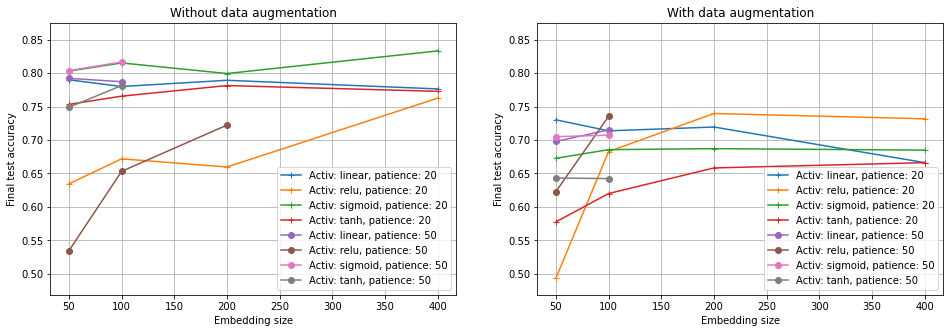

In [23]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, p in enumerate(pat):
        for act in act_fn:
            sublog_df = log_df.loc[np.logical_and(log_df['patience']==p, log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==DA[i]]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Final_test_accuracy'], plt_symbol[j], label = f"Activ: {act}, patience: {p}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Final test accuracy')
axs[0].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[1].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[0].set_title('Without data augmentation')
axs[1].set_title('With data augmentation')
axs[0].grid()
axs[1].grid();

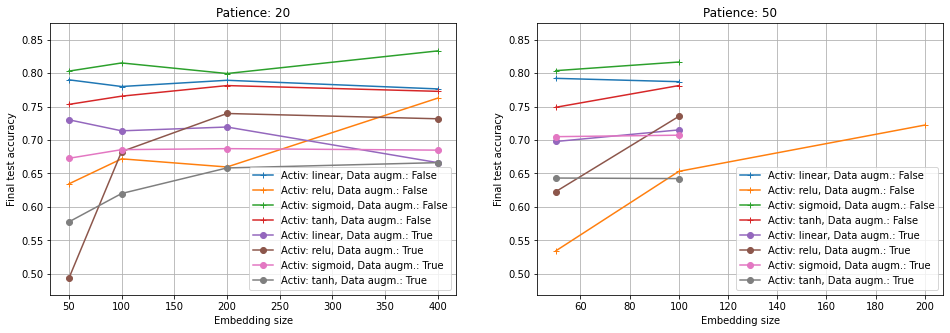

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
for i, ax in enumerate(axs):
    for j, da in enumerate(DA):
        for act in act_fn:
            sublog_df = log_df.loc[np.logical_and(log_df['patience']==pat[i], log_df['Last_layer_activation']==act)]
            sublog_df2 = sublog_df.loc[sublog_df['Data_augmentation']==da]
            sublog_df2 = sublog_df2.sort_values('Embedding_size', ascending=True)
            ax.plot(sublog_df2['Embedding_size'], sublog_df2['Final_test_accuracy'], plt_symbol[j], label = f"Activ: {act}, Data augm.: {da}")
    ax.legend()
    ax.set_xlabel('Embedding size')
    ax.set_ylabel('Final test accuracy')
axs[0].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[1].set_ylim([0.95*log_df['Final_test_accuracy'].min(), 1.05*log_df['Final_test_accuracy'].max()])
axs[0].set_title('Patience: 20')
axs[1].set_title('Patience: 50')
axs[0].grid()
axs[1].grid();

## Models heatmaps and history

In [25]:
path_data_test = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Test'
path_data_test = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Test_small'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
test_dataset = image_dataset_from_directory(path_data_test, shuffle=False, batch_size=BATCH_SIZE, image_size=IMG_SIZE, label_mode='categorical')

class_names = test_dataset.class_names
n_artist = len(class_names)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
print('Number of test batches: %d' % cardinality(test_dataset))

Found 58 files belonging to 12 classes.
Number of test batches: 2


In [26]:
label = np.concatenate([label for im, label in test_dataset])

In [27]:
artist_label = np.argmax(label, axis = 1)
len(artist_label)

58

In [28]:
img_list = []
for dir_path in os.listdir(path_data_test):
    img_list += os.listdir(os.path.join(path_data_test, dir_path))
artist_pred_df = pd.DataFrame({'Image_id': img_list, 'artist_id': artist_label})
artist_pred_df.head(5)

,Image_id,artist_id
0,1105.jpg,0
1,13.jpg,0
2,1558.jpg,0
3,1703.jpg,0
4,971.jpg,0


In [29]:
def plot_history(ax, history):
    ind_min = np.argmin(history['val_loss'])
    ax[1].plot(history['loss'], label='Train set loss')
    ax[1].plot(history['val_loss'], label='Validation set loss')
    ax[1].plot(ind_min, history['val_loss'].iloc[ind_min], 'r+')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[2].plot(history['accuracy'], label='Train set accuracy')
    ax[2].plot(history['val_accuracy'], label='Validation set accuracy')
    ax[2].plot(ind_min, history['val_accuracy'].iloc[ind_min], 'r+')
    ax[2].legend()
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('Accuracy');

In [ ]:
%%time
for i, model in enumerate(models_list):
    print(f"Model {i+1}/{len(models_list)}")
    trained_model = load_model(os.path.join(path_models, model))

    artist_proba = trained_model.predict(test_dataset)
    artist_pred_df[model] = np.argmax(artist_proba, axis = 1)
    acc = sum(artist_pred_df['artist_id'] == artist_pred_df[model])/len(artist_pred_df)
    artist_confusion_matrix = confusion_matrix(artist_pred_df['artist_id'], artist_pred_df[model])
    disp = ConfusionMatrixDisplay(artist_confusion_matrix)
    fig, ax = plt.subplots(1, 3, figsize = (20,6))
    disp.plot(ax = ax[0])
    ax[0].set_title(f'Test set accuracy = {acc:.3f}')
    
    history = log_df.loc[log_df['name'] == model, 'History'].iloc[0]
    plot_history(ax, history);

Model 1/49
Model 2/49
Model 3/49


## Models efficiency per artwork comparison

In [ ]:
artist_success_df = artist_pred_df.drop(columns=['Image_id', 'artist_id'])
for col in artist_success_df.columns:
    artist_success_df[col] = (artist_pred_df[col] == artist_pred_df['artist_id'])*1.0
artist_success_df['Success_rate'] = artist_success_df.sum(axis = 1)/artist_success_df.shape[1]
sns.displot(artist_success_df['Success_rate'], kde=True);

In [ ]:
artist_success_df.head()